In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import dataloader

from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder

from models import MyTransformer, MyVGG
from utils import get_best_threshold

In [8]:
LMDB_PATH_HOST="/home/jovyan/data/HWR.2021-11-08/lmdb.hwr_40-1.0"
TRN_DATA="/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.trn.550.shuf"
TST_DATA="/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.tst.550"
VAL_DATA="/home/jovyan/data/HWR.2021-11-08/dataset_gt/pero.ceske_dopisy.ceske_kroniky.embed/final.2021-11-18/lines.filtered_max_width.val.550.shuf"

In [9]:
def imshow(img, figsize=(4, 8)):
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_decision(is_match):
    if is_match:
        print("Same writer")
    else:
        print("Different writer")

In [19]:
dataset = dataloader.DatasetFromLMDB(lmdb_path=LMDB_PATH_HOST, labels_path=VAL_DATA, augment=False)

labels_to_indices = c_f.get_labels_to_indices([row[1] for row in dataset])

# model = MyTransformer()
# checkpoint = torch.load("model/with_transformer_grayscale_tiles_augment_only_on_train_night_100.pth")

model = MyVGG()
checkpoint = torch.load("model/with_vgg_20.pth")

model.load_state_dict(checkpoint)
model.to(torch.device("cuda"))

print("done model loading")

done model loading


In [20]:
match_finder = MatchFinder(distance=CosineSimilarity())
inference_model = InferenceModel(model, match_finder=match_finder)

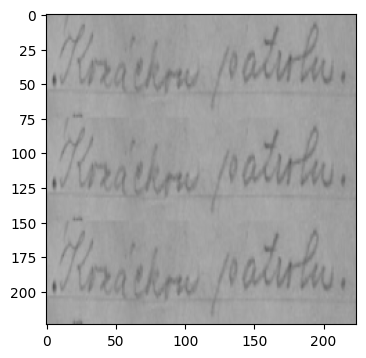

In [21]:
imshow(dataset[0][0])


In [22]:
inference_model.train_knn(dataset)

In [27]:
def get_accuracies(inf_model, thresholds):
    accuracies = []
    
    for threshold in thresholds:
        good = 0
        wrong = 0
        
        all_ids = labels_to_indices.values()
        all_ids = [item for sublist in all_ids for item in sublist]
        
        for target_writer, target_ids in labels_to_indices.items():          
            mask = np.isin(all_ids, target_ids, invert=True)
            non_target_ids = np.array(all_ids)[mask]
            picked_same = np.random.choice(target_ids, (50,2))
            
            picked_non_target = np.random.choice(non_target_ids, 50)
            picked_target = np.random.choice(target_ids, 50)
            picked_different = np.vstack((picked_non_target, picked_target)).T
            
            for a in picked_same:
                (x, _), (y, _) = dataset[a[0]], dataset[a[1]]
                decision = inf_model.is_match(x.unsqueeze(0), y.unsqueeze(0), threshold=threshold)
                if decision == True:
                    good += 1
                else:
                    wrong += 1
        
            for a in picked_different:
                (x, _), (y, _) = dataset[a[0]], dataset[a[1]]
                decision = inf_model.is_match(x.unsqueeze(0), y.unsqueeze(0), threshold=threshold)
                if decision == False:
                    good += 1
                else:
                    wrong += 1
    
        accuracies.append(good/(good+wrong))        
    return accuracies


# 0.55555555 for VGG / 0.333333 for transformer
# thresholds=[0.5555555]
# thresholds = [0.33333333]

# get_accuracies(thresholds)

In [ ]:
accuracies = []

for i in range(5,100,5):
    model = MyTransformer()
    checkpoint = torch.load(f"model/with_transformer_grayscale_tiles_augment_only_on_train_night_{i}.pth")
    
    model.load_state_dict(checkpoint)
    model.to(torch.device("cuda"))
    
    match_finder = MatchFinder(distance=CosineSimilarity())
    inference_model = InferenceModel(model, match_finder=match_finder)
    inference_model.train_knn(dataset)
    
    acc = get_accuracies(inference_model, [0.333333])[0]

    accuracies.append(acc)

In [31]:
print(accuracies)

[0.9257142857142857, 0.9604761904761905, 0.9666666666666667, 0.9638095238095238, 0.96, 0.9666666666666667, 0.9738095238095238, 0.9738095238095238, 0.9685714285714285, 0.9738095238095238, 0.9752380952380952, 0.9733333333333334, 0.9719047619047619, 0.9823809523809524, 0.9680952380952381, 0.9657142857142857, 0.9761904761904762, 0.9747619047619047, 0.9780952380952381]


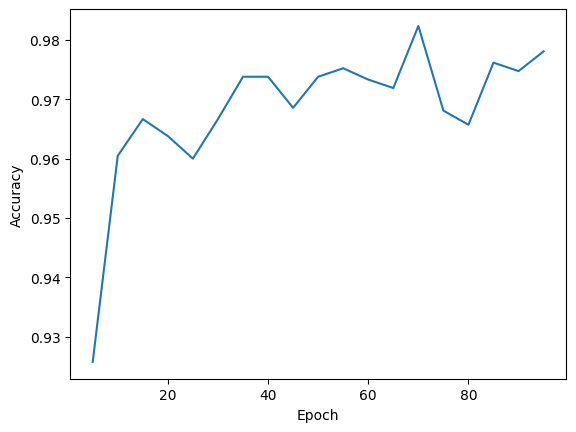

In [34]:

x = list(range(5,100,5))
 
# Plotting the Graph
plt.plot(x,accuracies)
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()